In [1]:
from scipy.linalg import solve
from scipy.special import erf as erf
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import os, pickle
import sys
data_dir = '.'

In [5]:
# max number of st/00 st/01 .. chunks to use
max_i = 9
# person
subject = 1
# seconds offset between movie and brain data
lag = 1
# maximum number of time points to use
max_seconds = 8000
# maximum number of voxels to use
max_voxels = 59928
# fraction of data that is training
train_frac = 0.8
# object that is being used
object_name = sys.argv[1]
# object_name = 'chair'

# load movie data
movie_data = ['' for _ in range(max_i)]
for i in range(max_i):
    objects_file = os.path.join(data_dir, 'st', '%02i_objects.pkl' % (i, ))
    with open(objects_file, 'rb') as f:
        movie_data[i] = pickle.load(f)

objects = [d for l in movie_data for d in l]
unique_objects = np.unique([k for d in objects for k in d])
n_frames = len(objects)
n_unique_objects = unique_objects.shape[0]
object_index = dict(zip(unique_objects, range(n_unique_objects)))

confidence = np.zeros((n_unique_objects, n_frames))
for frame, d in enumerate(objects):
    for o, c in d.items():
        confidence[object_index[o], frame] = c
barcode = ~np.isclose(confidence, 0)

# objects_to_infer = ['airplane', 'chair', 'tie']
# n_objects_to_infer = len(objects_to_infer)
# objects_to_infer_idx = [object_index[o] for o in objects_to_infer]
# objects_data = confidence[objects_to_infer_idx]
# objects_data = np.stack([o.mean(1) for o in np.split(objects_data, n_frames / 15, axis=1)]).T
# objects_data = np.roll(objects_data, lag)


object_confidence = confidence[object_index[object_name]]
object_mean = np.array([x.mean() for x in np.split(object_confidence, n_frames / 15)])
object_mean = np.roll(object_mean, lag)

# load brain data
brain_data = [
    np.load(
        os.path.join(data_dir, 'subject_%i' % (subject, ), 'rt', '%02i.npy' % (
            i, ))) for i in range(max_i)
]
brain_data = np.hstack(brain_data)
complete_vox = np.isclose(np.isnan(brain_data).sum(1), 0)
brain_data = brain_data[complete_vox]
vox_idx = np.random.choice(brain_data.shape[0], size=max_voxels, replace=False)
brain_data = brain_data[vox_idx]

In [7]:
# x = np.vstack((objects_data, brain_data))
x = np.vstack((object_mean, brain_data))
t = range(x.shape[1])
x = x[:, lag:lag+max_seconds]
t = t[lag:lag+max_seconds]

x -= x.mean(1)[:,np.newaxis]

split = int(x.shape[1] * train_frac)
x_train, x_test = x[:, :split], x[:, split:]
t_train, t_test = t[:split], t[split:]

x_train1, x_train2 = x_train[:, :-1], x_train[:, 1:]
t_train1, t_train2 = t_train[:-1], t_train[1:]

x_test1, x_test2 = x_test[:, :-1], x_test[:, 1:]
t_test1, t_test2 = t_test[:-1], t_test[1:]

In [4]:
# n, T = 20, int(1e4)
n, tn = x_train.shape
dt = 1.
l = np.int(np.ceil(tn / dt))
sqrt_dt = np.sqrt(dt)
sqrt_2 = np.sqrt(2)
rat = sqrt_dt / sqrt_2

sign_dx = np.sign(np.diff(x_train))
mean_x = x_train.mean(1)
cov_x = np.cov(x_train)
x_train1_mean0 = x_train1 - mean_x[:, np.newaxis]


def fit(i, iters=100):

    wi = np.zeros(n)
    wi[i] = 1

    # erf_last = erf(x1[i] * rat) + 1
    erf_last = erf(x_train1[i]) + 1

    e = []

    for it in range(iters):

        h = wi.dot(x_train1)

        erf_next = erf(h)
        ei = np.linalg.norm(erf_next - erf_last)
        e.append(ei)
        if ei * ei < 1e-5:
            break
        erf_last = erf_next.copy()

        h *= -sign_dx[i] / erf_next

        wi = solve(cov_x, x_train1_mean0.dot(h) / (l - 1))
    
#     print i, it, ei

    return wi, e[1:]

def predict(i, x):
    return x[i] + w[i].dot(x)

pool = mp.Pool(processes=mp.cpu_count())
# res = pool.map(fit, range(n_objects_to_infer))
res = pool.map(fit, range(n))
pool.close()
pool.terminate()
pool.join()

0 9 0.0028278361036634266
2 11 0.002927856745890598
1 14 0.0020348142626316424


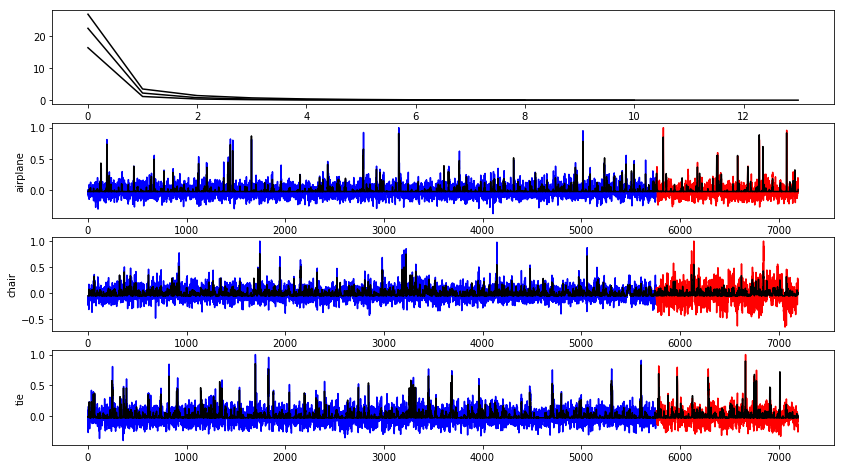

In [10]:
w = np.empty((n_objects_to_infer, n))
w = np.vstack([r[0] for r in res]) / rat
e = [r[1] for r in res]
np.save(object_name+'_w.npy', w)
np.save(object_name+'_e.npy', e)